In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
pip install textblob

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import re
import plotly.express as px
import plotly.graph_objects as go
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax

In [8]:
data = pd.read_excel('/content/drive/MyDrive/Elon_Tweets/twitter-elon-tesla- data.xlsx')
print(len(data))

34313


In [9]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [10]:
data['post'] = data['post'].astype(str)

In [11]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [12]:
def clean_text(text):
  #Removeing the @ and url links before I tokenize
  text = re.sub(r'@\w+', '', text)
  text = re.sub(r'http\S+|www\S+', '', text)
  text = text.lower()
  #Tokenize
  tokens = word_tokenize(text)
  tokens = [word for word in tokens if not word.startswith('@') and not word.startswith('http')]
  tokens = [word for word in tokens if word.isalpha()]
  tokens = [word for word in tokens if word not in stop_words]
  tokens = [lemmatizer.lemmatize(word) for word in tokens]
  text = ' '.join(tokens)
  return text


In [13]:
data['cleaned_post'] = data['post'].apply(clean_text)

In [14]:
def get_sentiment(text):
  analysis = TextBlob(text)
  return analysis.sentiment.polarity

data['sentiment_score'] = data['cleaned_post'].apply(get_sentiment)

In [15]:
def categorize_sentiment(score):
  if score > 0:
    return 'Positive'
  elif score < 0:
    return 'Negative'
  else:
    return 'Neutral'

data['sentiment_category'] = data['sentiment_score'].apply(categorize_sentiment)

In [16]:
print(data[['cleaned_post','sentiment_score','sentiment_category']])

                                            cleaned_post  sentiment_score  \
0       burning passion tesla way looker indeed congrats         0.000000   
1      deleted tweet c think elon musk fan pqrt tweet...         0.000000   
2      elon thank carlos rodriguez call start powerwa...         0.000000   
3      arguing tesla ca extend range innovate manufac...         0.250000   
4                cnbc report tesla installs solar roof u         0.000000   
...                                                  ...              ...   
34308                                                            0.000000   
34309  rt camp mode maintains cabin temperature airfl...         0.000000   
34310  rt woke mind virus parasite kill host must eli...         0.000000   
34311  rt tesla model highland may use catl new lfp b...         0.136364   
34312  rt camp mode maintains cabin temperature airfl...         0.000000   

      sentiment_category  
0                Neutral  
1                Neut

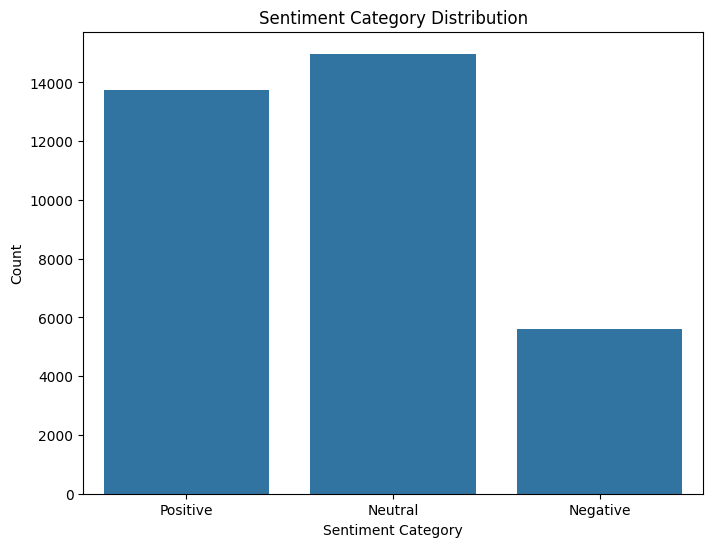

In [17]:
plt.figure(figsize=(8,6))
sns.countplot(x='sentiment_category',data=data,order = ['Positive','Neutral','Negative'])
plt.title('Sentiment Category Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

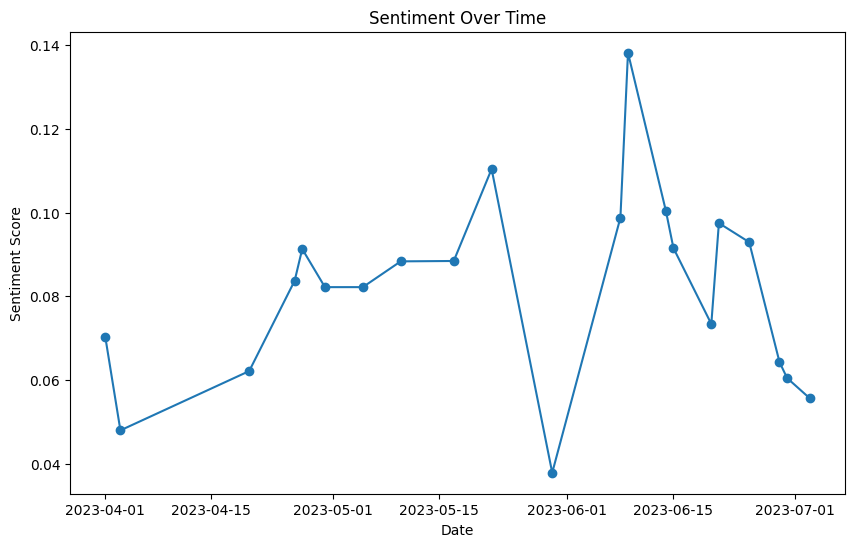

In [18]:
data['UTC Date'] = pd.to_datetime(data['UTC Date'])

sentiment_day = data.groupby(data['UTC Date'].dt.date)['sentiment_score'].mean()

plt.figure(figsize=(10,6))
plt.plot(sentiment_day.index,sentiment_day.values,marker='o',linestyle='-')
plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.show()

In [19]:
sentiment_count = data['sentiment_category'].value_counts().reset_index()
sentiment_count.columns = ['Sentiment','Count']

fig = px.bar(sentiment_count, x = 'Sentiment', y = 'Count', title = 'Sentiment Category Distribution',color_discrete_map={'Positive':'green','Neutral':'yellow','Negative':'red'})
fig.update_layout(bargap=0.2,template='plotly_dark')
fig.show()


In [30]:
data['UTC Date'] = pd.to_datetime(data['UTC Date'], errors='coerce').dt.date

sentiment_time = data.groupby(['UTC Date','sentiment_category']).size().reset_index()
sentiment_time.columns = ['Date','Sentiment Category','Count']

fig = px.bar(sentiment_time,x='Date',y='Count',color='Sentiment Category',title='Sentiment Over Time',color_discrete_map={'Positive':'green','Neutral':'blue','Negative':'red'})
fig.show()

In [25]:
data['Weighted_Sentiment'] = data['sentiment_score'] * data['Impressions']

total_weighted_score = data['Weighted_Sentiment'].sum()
total_impressions = data['Impressions'].sum()

weighted_sentiment_score = total_weighted_score / total_impressions

bins = [0,100,1000,10000, float('inf')]
labels = ['low','medium','high','very high']

data['Impressions_Category'] = pd.cut(data['Impressions'],bins=bins,labels=labels)

grouped_sentiment = data.groupby('Impressions_Category')['sentiment_score'].mean()

print(total_weighted_score)
print(weighted_sentiment_score)
print(grouped_sentiment)

4779645.748132324
0.04415057822868704
Impressions_Category
low          0.080940
medium       0.081919
high         0.109885
very high    0.089160
Name: sentiment_score, dtype: float64


<ipython-input-25-835833f0bab6>:15: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



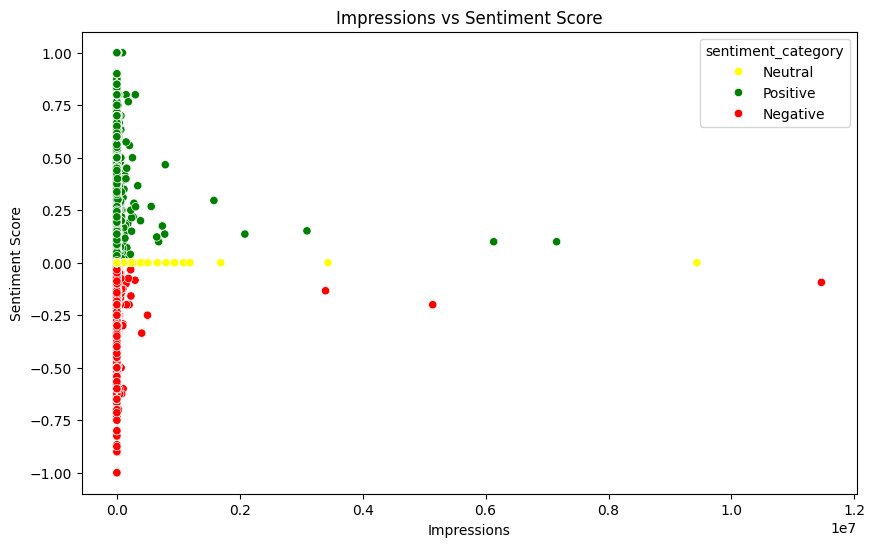

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.scatterplot(x='Impressions', y='sentiment_score', data=data, hue='sentiment_category', palette={'Positive':'green','Neutral':'yellow','Negative':'red'})
plt.xlabel('Impressions')
plt.ylabel('Sentiment Score')
plt.title('Impressions vs Sentiment Score')
plt.show()

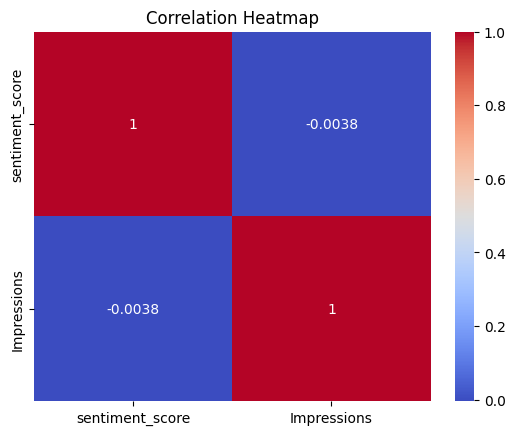

In [29]:
sns.heatmap(correlation,annot=True,cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()